<a href="https://colab.research.google.com/github/mahidhiman12/Deep_learning_with_PyTorch/blob/main/8_PyTorch_Transfer_Learning_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our previous model's performance up until now is pretty bad. Often times , theres always a well performing model that exists for our problem.We can use it : This technique is called **`transfer learning`**

**What is transfer learning?**

Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a language model (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.

**Why should we use transfer learning:**

There are two main benefits to using transfer learning:

Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

We'll be putting these to the test for our FoodVision Mini problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.

> A study into the effects of whether training from scratch or using transfer learning was better from a practitioner's point of view, found transfer learning to be far more beneficial in terms of cost and time.

Where can we find pretrained models ?

| **Location** | **What's there?** | **Link(s)** |
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets |
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ |



> state of the art : State-of-the-art (SOTA) machine learning refers to the most advanced and accurate models, algorithms, and techniques currently available for a specific task.


**We're going to take a pretrained model from torchvision.models and customise it to work on our FoodVision Mini problem.**

## 0. Getting Setup

Lets start by leveraging some of the Python Scripts we created in last notebook.

- We will download `going_modular` directory
- `torchinfo` will help later on to give us a visual representation of our model.

In [1]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version : {torch.__version__}")
  print(f"torchvision version : {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.9.0+cu128


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 46.33 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data:

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVision Mini.

In [8]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "ic_pancake_ramen_nachos20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download data
    with open(data_path / "ic_pancake_ramen_nachos20_percent.zip", "wb") as f:
        request = requests.get("https://github.com/mahidhiman12/Deep_learning_with_PyTorch/raw/main/ic_pancake_ramen_nachos20_percent.zip")
        print("Downloading data...")
        f.write(request.content)

    # Unzip  data
    with zipfile.ZipFile(data_path / "ic_pancake_ramen_nachos20_percent.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(data_path)

    # Remove .zip file
    os.remove(data_path / "ic_pancake_ramen_nachos20_percent.zip")

data/ic_pancake_ramen_nachos20_percent directory exists.


In [11]:
import shutil, zipfile
from pathlib import Path

data_path = Path("data/")
zip_path = data_path / "ic_pancake_ramen_nachos20_percent.zip"
extract_path = data_path / "ic_pancake_ramen_nachos20_percent"

# delete old empty folder if it exists
if extract_path.exists():
    shutil.rmtree(extract_path)

# extract zip straight into data/
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    print("Extracting...")
    zip_ref.extractall(data_path)

print("After extraction:", os.listdir(data_path))


Extracting...
After extraction: ['train', 'ic_pancake_ramen_nachos20_percent.zip', 'test']


In [13]:
import shutil, os
from pathlib import Path

data_path = Path("data/")
target_dir = data_path / "ic_pancake_ramen_nachos20_percent"

# create the folder if not there
target_dir.mkdir(parents=True, exist_ok=True)

# move train + test into it
for folder in ["train", "test"]:
    src = data_path / folder
    dst = target_dir / folder
    if src.exists():
        shutil.move(str(src), str(dst))
        print(f"Moved {folder} into {target_dir}")


Moved train into data/ic_pancake_ramen_nachos20_percent
Moved test into data/ic_pancake_ramen_nachos20_percent


In [6]:
train_dir = image_path/"train"
test_dir = image_path / "test"

## 2. Create datasets and dataloaders

Since we've downloaded the going_modular directory, we can use the data_setup.py script we created in section 07. PyTorch Going Modular to prepare and setup our DataLoaders.
We will call this `manual creation`

But since we'll be using a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first. We will call this `auto creation`

### 2.1 Manual Creation

> **When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.**

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of:

| **Transform number** | **Transform required** | **Code to perform transform** |
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  |

> **Note:** some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [15]:
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
    ])

We'll set batch_size=32 so our model sees mini-batches of 32 samples at a time.

In [16]:


train_dataloader , test_dataloader , class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                 test_dir=test_dir,
                                                                                 transform=manual_transforms,
                                                                                 batch_size=32)
train_dataloader , test_dataloader , class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff00aba8260>,
 ['ice_cream', 'nachos', 'pancakes', 'ramen'])

In [17]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [18]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [19]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 174MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [20]:
summary(model = model,
        input_size = (32,3,224,224),
        col_names=["input_size" , "output_size" , "num_params" , "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [21]:
for param in model.features.parameters():
  param.requires_grad=False


In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [23]:
summary(model = model,
        input_size = (32,3,224,224),
        verbose=0,
        col_names=["input_size" , "output_size" , "num_params" , "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [24]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_timer = timer()
results = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)
end_timer = timer()
print(f"Total training time : {end_timer-start_timer:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2330 | train_acc: 0.9567 | test_loss: 0.3957 | test_acc: 0.8705
Epoch: 2 | train_loss: 0.2306 | train_acc: 0.9578 | test_loss: 0.3769 | test_acc: 0.8839
Epoch: 3 | train_loss: 0.2224 | train_acc: 0.9616 | test_loss: 0.4093 | test_acc: 0.8750
Epoch: 4 | train_loss: 0.1964 | train_acc: 0.9682 | test_loss: 0.3785 | test_acc: 0.8750
Epoch: 5 | train_loss: 0.2106 | train_acc: 0.9605 | test_loss: 0.3849 | test_acc: 0.8705
Epoch: 6 | train_loss: 0.2279 | train_acc: 0.9507 | test_loss: 0.3851 | test_acc: 0.8750
Epoch: 7 | train_loss: 0.2026 | train_acc: 0.9572 | test_loss: 0.3777 | test_acc: 0.8705
Epoch: 8 | train_loss: 0.2113 | train_acc: 0.9507 | test_loss: 0.3676 | test_acc: 0.8750
Epoch: 9 | train_loss: 0.1862 | train_acc: 0.9589 | test_loss: 0.3851 | test_acc: 0.8750
Epoch: 10 | train_loss: 0.1825 | train_acc: 0.9638 | test_loss: 0.3640 | test_acc: 0.8750
Total training time : 39.1362 seconds


In [29]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

[INFO] Couldn't find helper_functions.py, downloading...


In [30]:
from typing import List , Tuple
from PIL import Image
def pred_and_plot(model:torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # open image
  img = Image.open(image_path)

  # create transform
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

  # predict
  model.to(device)
  model.eval()
  with torch.inference_mode():
    # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))

  # convert logits -> pred probs
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

  # convert pred probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

  # plot image with pred label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred : {class_names[target_image_pred_label]} | Prob : {target_image_pred_probs.max():.3f}")
  plt.axis(False)

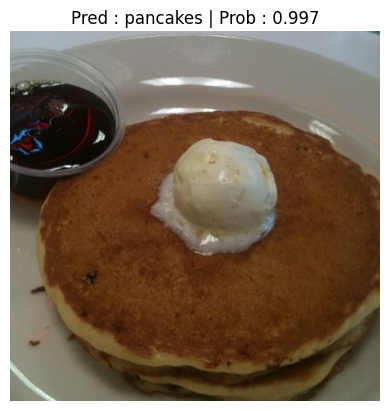

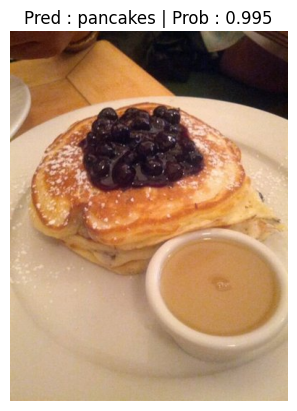

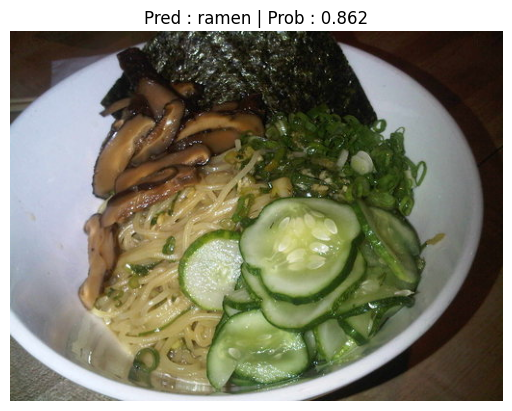

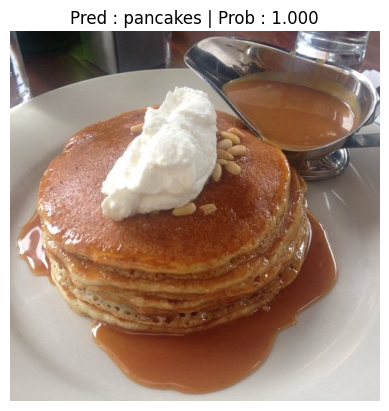

In [33]:
import random
num_images_to_plot = 4
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
for image_path in test_image_path_sample:
    pred_and_plot(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))